In [1]:
import pandas as pd
from google.cloud import bigquery
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# Creating a function for displaying missing values

def missing_values(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.reset_index()
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table_ren_columns.rename(columns= {'index': 'Column', 0: 'Missing Values', 1: '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Loading Count of Unique Active Consumers per FSA

In [81]:
client = bigquery.Client(project='senso-bmo-production')

sql="""
SELECT
  pty_addr_fsa,
  COUNT(DISTINCT tu_consumer_id) AS consumer_count
FROM (
  SELECT
    *
  FROM
    `senso-bmo-production.cleaned_data.mortgage_application_data`
  WHERE
    run_date = '2020-09-01'
    AND loan_st_cd = 'A'
    AND pty_typ_cd = 1)
GROUP BY
  1
ORDER BY
  2 DESC
"""

In [82]:
query_job = client.query(sql)
fsa_df = query_job.to_dataframe() 

In [83]:
fsa_df.head()

pty_addr_fsa  consumer_count
0          m5v            2241
1          t6w            2205
2          k0k            2164
3          m2n            2119
4          t3k            1781

In [84]:
missing_values(fsa_df)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


Column  Missing Values  % of Total Values
0  pty_addr_fsa               1                0.1

In [85]:
fsa_df['pty_addr_fsa'] = fsa_df['pty_addr_fsa'].str.upper()
fsa_df.rename(columns={'pty_addr_fsa': 'postal_code', 'consumer_count':'consumer_cnt_bmo'}, inplace=True)
fsa_df.dropna(inplace=True)

In [86]:
fsa_df.head()

postal_code  consumer_cnt_bmo
0         M5V              2241
1         T6W              2205
2         K0K              2164
3         M2N              2119
4         T3K              1781

### Adding in FSA Coordinates

In [87]:
postal = pd.read_csv('ca_postal_codes.csv')
postal.head()

Postal Code                          Place Name Province  Latitude  \
0         T0A          Eastern Alberta (St. Paul)       AB   54.7660   
1         T0B         Wainwright Region (Tofield)       AB   53.0727   
2         T0C          Central Alberta (Stettler)       AB   52.1431   
3         T0E            Western Alberta (Jasper)       AB   53.6758   
4         T0G  North Central Alberta (Slave Lake)       AB   55.6993   

   Longitude  Unnamed: 5  Unnamed: 6  
0  -111.7174         NaN         NaN  
1  -111.5816         NaN         NaN  
2  -111.6941         NaN         NaN  
3  -115.0948         NaN         NaN  
4  -114.4529         NaN         NaN

In [88]:
postal.drop(columns=['Unnamed: 5', 'Unnamed: 6'], inplace=True)
postal.rename(columns={'Postal Code': 'postal_code', 'Place Name':'place_name', 'Province': 'province', 'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)

In [89]:
missing_values(postal)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.


Column  Missing Values  % of Total Values
3    lat               9                0.5
4    lon               2                0.1

In [90]:
postal[postal.isna().any(axis=1)]

postal_code             place_name  \
208          V0N           North Island   
416          E1H              Lakeville   
423          E2E               Rothesay   
425          E2H   Saint John Northeast   
437          E3C  Fredericton Southwest   
647          K0H       Frontenac County   
729          K0C               Stormont   
732          K0K          Quinte Shores   
1123         P0M                 Algoma   

                                             province  lat      lon  
208              and Southern Gulf Islands (Whistler)  NaN      NaN  
416                                     New Brunswick  NaN  46.1732  
423                                     New Brunswick  NaN  45.4137  
425                                     New Brunswick  NaN  45.3500  
437                                     New Brunswick  NaN  45.9020  
647    Loyalist Shores and Southwest Leeds (Inverary)  NaN      NaN  
729                                           Ontario  NaN  45.1686  
732                                           Ontario  NaN  44.3261  
1123                                          Ontario  NaN  47.6526

In [91]:
# Inserting / Overwriting missing FSAs with correct values

postal['lat'].loc[(postal['postal_code'] == 'V0N')] = 50.5666
postal['lon'].loc[(postal['postal_code'] == 'V0N')] = -122.6979

postal['lat'].loc[(postal['postal_code'] == 'E1H')] = 46.1946
postal['lon'].loc[(postal['postal_code'] == 'E1H')] = -64.7356

postal['lat'].loc[(postal['postal_code'] == 'E2E')] = 45.4186
postal['lon'].loc[(postal['postal_code'] == 'E2E')] = -65.9664

postal['lat'].loc[(postal['postal_code'] == 'E2H')] = 45.3437
postal['lon'].loc[(postal['postal_code'] == 'E2H')] = -66.0101

postal['lat'].loc[(postal['postal_code'] == 'E3C')] = 45.8623
postal['lon'].loc[(postal['postal_code'] == 'E3C')] = -66.6683

postal['lat'].loc[(postal['postal_code'] == 'K0H')] = 44.7666
postal['lon'].loc[(postal['postal_code'] == 'K0H')] = -76.8720

postal['lat'].loc[(postal['postal_code'] == 'K0C')] = 45.1228
postal['lon'].loc[(postal['postal_code'] == 'K0C')] = -74.8733

postal['lat'].loc[(postal['postal_code'] == 'K0K')] = 44.3806
postal['lon'].loc[(postal['postal_code'] == 'K0K')] = -77.4385

postal['lat'].loc[(postal['postal_code'] == 'P0M')] = 47.6911
postal['lon'].loc[(postal['postal_code'] == 'P0M')] = -82.7213

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [92]:
missing_values(postal)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Column, Missing Values, % of Total Values]
Index: []

In [93]:
# Merging property fsa coordinates with the count of unique, active consumers for the most recent month of data per fsa

postal_df = pd.merge(postal, fsa_df, on='postal_code')

In [94]:
postal_df.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  
0               334  
1               789  
2               669  
3               322  
4               177

This is for property addresses, not mailing addresses

### Adding Avg. Null Counts per FSA

In [95]:
sql = """
SELECT
  pty_addr_fsa AS postal_code,
  COUNT(DISTINCT tu_consumer_id) AS null_consumer_count,
  AVG(null_sum) AS avg_null_count
FROM (
  SELECT
    DISTINCT *,
    ((CASE
          WHEN ann_inc_cd IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN occptn_cd IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN appl_dt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN first_advnc_dt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN purp_of_loan_cd IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN auth_loan_amt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN amz_prd_mth_cnt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN gds_ratio IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN tds_ratio IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN BMO_ins_ind IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN loan_insrr_cd IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN ins_loan_ratio IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN pty_typ_cd IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN nbr_dwlg_unit_cnt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN aprs_val_amt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN loan_st_cd IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN CBR_risk_scr IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN adjud_dt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_PROPERTY_AGE IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_SIZE_OF_BUILDING IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_PREV_SALE_PRICE IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_PREV_SALE_CLOSE_DATE IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_GARAGE_SIZE IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_DOWN_PAYMENT_AMT IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN MTG_DOWNPMT_SOURCE_CODE IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN cust_since_dt IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN tu_consumer_id IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN birth_month IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN brwr_addr_fsa IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN pty_addr_fsa IS NULL THEN 1
        ELSE
        0
      END
        ) + (CASE
          WHEN run_date IS NULL THEN 1
        ELSE
        0
      END
        ) ) null_sum
  FROM (
    SELECT
      *
    FROM
      `senso-bmo-production.cleaned_data.mortgage_application_data`
    WHERE
      run_date = '2020-09-01'
      AND loan_st_cd = 'A'
      AND pty_typ_cd = 1))
WHERE
  pty_addr_fsa IS NOT NULL
GROUP BY
  1
ORDER BY
  2 DESC
"""

There is a blind spot to the above SQL logic in the sense that we must aggregate the sum of null-value columns per consumer to the FSA level. What if the FSA itself is missing, however? In that case, that particular record would not be aggregated at all and the metric itself loses some accuracy. Assuming that consumers with a missing FSA will tend to have other features missing also (we can get numbers on this later), then it might be reasonable to say that this null_sum metric, in its current state, might paint a rosier picture of the data than is deserved.

In [96]:
query_job = client.query(sql)
null_counts = query_job.to_dataframe()

In [97]:
null_counts.head()

postal_code  null_consumer_count  avg_null_count
0         m5v                 2241        1.738507
1         t6w                 2205        0.942092
2         k0k                 2164        1.707973
3         m2n                 2119        1.984793
4         t3k                 1781        1.930169

In [98]:
null_counts.drop(columns=['null_consumer_count'], inplace=True)

In [99]:
null_counts['postal_code'] = null_counts['postal_code'].str.upper()

In [100]:
postal_3 = pd.merge(postal_df, null_counts, on='postal_code')

In [101]:
postal_3.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count  
0               334        2.364706  
1               789        2.074166  
2               669        2.257225  
3               322        1.426380  
4               177        1.994413

In [102]:
postal_3['avg_null_count'] = postal_3['avg_null_count'].map(lambda n: '{:,.2f}'.format(n))
postal_3['avg_null_count'] = postal_3['avg_null_count'].astype(float)

## Distinguishing Urban and Rural FSAs

In [103]:
def urban_rural(x):
    if '0' in x:
        return "rural"
    else:
        return "urban"

In [104]:
postal_3["area"] = postal_3["postal_code"].map(urban_rural)

In [105]:
postal_3.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  
0               334            2.36  rural  
1               789            2.07  rural  
2               669            2.26  rural  
3               322            1.43  rural  
4               177            1.99  rural

## Adding FSA-Level Population Data

In [106]:
pop_df = pd.read_csv('population_by_fsa.csv')

In [107]:
pop_df.head()

Geographic code Geographic name      Province or territory  \
0              01          Canada                        NaN   
1             A0A             A0A  Newfoundland and Labrador   
2             A0B             A0B  Newfoundland and Labrador   
3             A0C             A0C  Newfoundland and Labrador   
4             A0E             A0E  Newfoundland and Labrador   

  Incompletely enumerated Indian reserves and Indian settlements, 2016  \
0                                                  T                     
1                                                NaN                     
2                                                NaN                     
3                                                NaN                     
4                                                NaN                     

   Population, 2016  Total private dwellings, 2016  \
0        35151728.0                     15412443.0   
1           46587.0                        26155.0   
2           19792.0                        13658.0   
3           12587.0                         8010.0   
4           22294.0                        12293.0   

   Private dwellings occupied by usual residents, 2016  
0                                         14072079.0    
1                                            19426.0    
2                                             8792.0    
3                                             5606.0    
4                                             9603.0

We'll work with 'total private dwellings' instead of 'private dwellings occupied by usual residents' because we're trying to show all possible housing. There is always a market for a home regardless of whether or not someone usually lives in it. Also, it's possible a resident might be paying off a mortgage on a home they don't usually live in (i.e. a vacation home) - the likelihood or wisdom of that choice aside.

In [108]:
pop_df.drop([0], inplace=True)
pop_df.drop(columns=['Geographic name',
                     'Province or territory',
                     'Incompletely enumerated Indian reserves and Indian settlements, 2016',
                     'Population, 2016',
                     'Private dwellings occupied by usual residents, 2016'], inplace=True)
pop_df.rename(columns={'Geographic code': 'postal_code', 'Total private dwellings, 2016':'priv_dwell_2016'}, inplace=True)

In [109]:
pop_df.head()

postal_code  priv_dwell_2016
1         A0A          26155.0
2         A0B          13658.0
3         A0C           8010.0
4         A0E          12293.0
5         A0G          21750.0

In [110]:
postal_4 = pd.merge(postal_3, pop_df, on='postal_code')

In [111]:
postal_4.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  
0               334            2.36  rural          27713.0  
1               789            2.07  rural          28009.0  
2               669            2.26  rural          28739.0  
3               322            1.43  rural          22179.0  
4               177            1.99  rural          18519.0

## Adding in Market-Wide Mortgage Data

In [112]:
sql="""
SELECT
  *
FROM
  `senso-bmo-production.tu_data.market_wide_fsa_count`
"""

In [113]:
query_job = client.query(sql)
market_wide_df = query_job.to_dataframe() 

In [114]:
market_wide_df.head()

fsa  num_consumers
0  L9J            256
1  V9X           1792
2  T3Z           1792
3  P1L           2560
4  T1W           2560

In [115]:
market_wide_df.rename(columns={'fsa':'postal_code', 'num_consumers':'consumer_cnt_mw'}, inplace=True)

In [116]:
market_wide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   postal_code      2136 non-null   object
 1   consumer_cnt_mw  2137 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.5+ KB


In [117]:
market_wide_df.dropna(inplace=True)

In [118]:
postal_5 = pd.merge(postal_4, market_wide_df, on='postal_code')

In [119]:
postal_5.postal_code.value_counts()

C0A    2
K9H    1
B0L    1
G3E    1
X0A    1
      ..
V1W    1
V5X    1
T5S    1
J5A    1
H4N    1
Name: postal_code, Length: 1628, dtype: int64

In [120]:
postal_5.loc[postal_5['postal_code'] == 'C0A']

postal_code                          place_name province      lat  \
1157         C0A                            Montague       PE  46.1668   
1158         C0A  Kings and Queens counties (Elmira)       PE  46.1668   

          lon  consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  \
1157 -62.6487               936            1.87  rural          23867.0   
1158 -62.6487               936            1.87  rural          23867.0   

      consumer_cnt_mw  
1157             6650  
1158             6650

In [121]:
postal_5.drop_duplicates(subset='postal_code', keep='first', inplace=True)

In [122]:
postal_5.postal_code.value_counts()

K9H    1
P8N    1
B0L    1
G3E    1
X0A    1
      ..
V5X    1
T5S    1
J5A    1
T8N    1
H4N    1
Name: postal_code, Length: 1628, dtype: int64

In [123]:
postal_5.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  
0               334            2.36  rural          27713.0             6287  
1               789            2.07  rural          28009.0             6918  
2               669            2.26  rural          28739.0             6612  
3               322            1.43  rural          22179.0             5110  
4               177            1.99  rural          18519.0             4334

In [124]:
postal_5['bmo_mkt_share_total'] = postal_5['consumer_cnt_bmo'] / postal_5['consumer_cnt_mw']
postal_5.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               789            2.07  rural          28009.0             6918   
2               669            2.26  rural          28739.0             6612   
3               322            1.43  rural          22179.0             5110   
4               177            1.99  rural          18519.0             4334   

   bmo_mkt_share_total  
0             0.053125  
1             0.114050  
2             0.101180  
3             0.063014  
4             0.040840

In [125]:
postal_5['bmo_mkt_share_total'] = postal_5['bmo_mkt_share_total'].map(lambda n: '{:,.3f}'.format(n))
postal_5['bmo_mkt_share_total'] = postal_5['bmo_mkt_share_total'].astype(float)

In [126]:
postal_5.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               789            2.07  rural          28009.0             6918   
2               669            2.26  rural          28739.0             6612   
3               322            1.43  rural          22179.0             5110   
4               177            1.99  rural          18519.0             4334   

   bmo_mkt_share_total  
0                0.053  
1                0.114  
2                0.101  
3                0.063  
4                0.041

## Major Banks

In [127]:
sql="""
SELECT
  *
FROM
  `senso-bmo-production.tu_data.major_bank_fsa_count`
"""

In [128]:
query_job = client.query(sql)
major_bank_df = query_job.to_dataframe() 

In [129]:
major_bank_df.head()

fsa  num_consumers
0  G5R            256
1  T9G            768
2  H4B           1024
3  H1V           1024
4  H1H           1280

In [130]:
major_bank_df.rename(columns={'fsa':'postal_code', 'num_consumers':'consumer_cnt_mb'}, inplace=True)

In [131]:
major_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   postal_code      2056 non-null   object
 1   consumer_cnt_mb  2057 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.3+ KB


In [132]:
major_bank_df.dropna(inplace=True)

In [133]:
postal_6 = pd.merge(postal_5, major_bank_df, on='postal_code')

In [134]:
postal_6.postal_code.value_counts()

K9H    1
P8N    1
B0L    1
G3E    1
X0A    1
      ..
V5X    1
T5S    1
J5A    1
T8N    1
H4N    1
Name: postal_code, Length: 1628, dtype: int64

In [135]:
postal_6.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               789            2.07  rural          28009.0             6918   
2               669            2.26  rural          28739.0             6612   
3               322            1.43  rural          22179.0             5110   
4               177            1.99  rural          18519.0             4334   

   bmo_mkt_share_total  consumer_cnt_mb  
0                0.053             4353  
1                0.114             4330  
2                0.101             4194  
3                0.063             3700  
4                0.041             3231

In [136]:
postal_6['bmo_mkt_share_big_bnks'] = postal_6['consumer_cnt_bmo'] / postal_6['consumer_cnt_mb']
postal_6.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               789            2.07  rural          28009.0             6918   
2               669            2.26  rural          28739.0             6612   
3               322            1.43  rural          22179.0             5110   
4               177            1.99  rural          18519.0             4334   

   bmo_mkt_share_total  consumer_cnt_mb  bmo_mkt_share_big_bnks  
0                0.053             4353                0.076729  
1                0.114             4330                0.182217  
2                0.101             4194                0.159514  
3                0.063             3700                0.087027  
4                0.041             3231                0.054782

In [137]:
postal_6.describe()

lat          lon  consumer_cnt_bmo  avg_null_count  \
count  1628.000000  1628.000000       1628.000000     1628.000000   
mean     47.043402   -85.592932        299.226044        1.832875   
std       3.423709    19.733992        302.249227        0.825006   
min      42.050200  -137.536000          1.000000        0.000000   
25%      44.637550   -99.775675         99.000000        1.410000   
50%      45.894950   -79.360350        221.000000        1.770000   
75%      49.237225   -73.208125        388.250000        2.140000   
max      79.621800   -52.672900       2241.000000        9.000000   

       priv_dwell_2016  consumer_cnt_mw  bmo_mkt_share_total  consumer_cnt_mb  \
count      1628.000000      1628.000000          1628.000000      1628.000000   
mean       9463.324939      3292.211302             0.094329      2188.789926   
std        7231.042898      2928.508153             0.071840      2147.868230   
min           1.000000         5.000000             0.001000         3.000000   
25%        4176.500000      1393.250000             0.061750       736.250000   
50%        8156.000000      2565.500000             0.086000      1625.500000   
75%       13181.500000      4275.750000             0.113000      2894.000000   
max       75674.000000     33611.000000             1.417000     16757.000000   

       bmo_mkt_share_big_bnks  
count             1628.000000  
mean                 0.149321  
std                  0.099995  
min                  0.002632  
25%                  0.098277  
50%                  0.129676  
75%                  0.179937  
max                  1.666667

In [138]:
postal_6['bmo_mkt_share_big_bnks'] = postal_6['bmo_mkt_share_big_bnks'].map(lambda n: '{:,.3f}'.format(n))
postal_6['bmo_mkt_share_big_bnks'] = postal_6['bmo_mkt_share_big_bnks'].astype(float)

In [139]:
postal_6.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               789            2.07  rural          28009.0             6918   
2               669            2.26  rural          28739.0             6612   
3               322            1.43  rural          22179.0             5110   
4               177            1.99  rural          18519.0             4334   

   bmo_mkt_share_total  consumer_cnt_mb  bmo_mkt_share_big_bnks  
0                0.053             4353                   0.077  
1                0.114             4330                   0.182  
2                0.101             4194                   0.160  
3                0.063             3700                   0.087  
4                0.041             3231                   0.055

In [68]:
# postal_6.to_gbq('processed_data.fsa_data', project_id='senso-bmo-production', if_exists='replace')

1it [00:03,  3.06s/it]


In [66]:
postal_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1628 entries, 0 to 1627
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   postal_code             1628 non-null   object 
 1   place_name              1628 non-null   object 
 2   province                1628 non-null   object 
 3   lat                     1628 non-null   float64
 4   lon                     1628 non-null   float64
 5   consumer_cnt_bmo        1628 non-null   int64  
 6   avg_null_count          1628 non-null   float64
 7   area                    1628 non-null   object 
 8   priv_dwell_2016         1628 non-null   float64
 9   consumer_cnt_mw         1628 non-null   int64  
 10  bmo_mkt_share_total     1628 non-null   float64
 11  consumer_cnt_mb         1628 non-null   int64  
 12  bmo_mkt_share_big_bnks  1628 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 178.1+ KB


In [69]:
postal_6.bmo_mkt_share_total.describe()

count    1628.000000
mean        0.095146
std         0.072155
min         0.001000
25%         0.062000
50%         0.087000
75%         0.114000
max         1.417000
Name: bmo_mkt_share_total, dtype: float64

In [152]:
postal_6.bmo_mkt_share_total.describe()

count    1628.000000
mean        0.094329
std         0.071840
min         0.001000
25%         0.061750
50%         0.086000
75%         0.113000
max         1.417000
Name: bmo_mkt_share_total, dtype: float64

In [153]:
postal_6.bmo_mkt_share_big_bnks.describe()

count    1628.000000
mean        0.149332
std         0.099989
min         0.003000
25%         0.098000
50%         0.130000
75%         0.180000
max         1.667000
Name: bmo_mkt_share_big_bnks, dtype: float64

In [70]:
postal_6.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               818            2.41  rural          28009.0             6918   
2               692            2.52  rural          28739.0             6612   
3               327            1.55  rural          22179.0             5110   
4               181            2.21  rural          18519.0             4334   

   bmo_mkt_share_total  consumer_cnt_mb  bmo_mkt_share_big_bnks  
0                0.053             4353                   0.077  
1                0.118             4330                   0.189  
2                0.105             4194                   0.165  
3                0.064             3700                   0.088  
4                0.042             3231                   0.056

In [162]:
top_25 = postal_6.sort_values(by='bmo_mkt_share_total', ascending=False).head(25)

postal_code                                         place_name province  \
1407         H0M                       Akwesasne Region (Akwesasne)       QC   
11           T0V                      Remote Northeast (Fitzgerald)       AB   
213          V0V                         Lower Skeena (Port Edward)       BC   
533          A0R           North/Western Labrador (Churchill Falls)       NL   
593          B2J                                            Fourchu       NS   
530          A0M  Southwestern Newfoundland (Channel-Port aux Ba...       NL   
526          A0H               Central Newfoundland (Bishops Falls)       NL   
527          A0J                 Northern Newfoundland (Springdale)       NL   
1111         P0P                        Manitoulin (Little Current)       ON   
555          A8A                                          Deer Lake       NL   
586          B1W                                           Eskasoni       NS   
553          A2V                                      Labrador City       NL   
1153         P8T                                      Sioux Lookout       ON   
552          A2N                                       Stephenville       NL   
531          A0N       Port au Port Peninsula region (St. George's)       NL   
551          A2H                                       Corner Brook       NL   
529          A0L                Western Newfoundland (Lark Harbour)       NL   
1472         H4Y                                     Dorval Central       QC   
19           T1L                                              Banff       AB   
228          V1R                                              Trail       BC   
1275         J8E                                     Mont-Tremblant       QC   
226          V1N                                          Castlegar       BC   
1510         J0M                                 Nunavik (Kuujjuaq)       QC   
550          A2B                                            Windsor       NL   
549          A2A                                        Grand Falls       NL   

          lat       lon  consumer_cnt_bmo  avg_null_count   area  \
1407  45.6986  -73.5025                51            6.06  rural   
11    59.9049 -111.6717                 5            4.40  rural   
213   53.9725 -129.8986               109            4.18  rural   
533   53.5400  -65.1120               268            1.24  rural   
593   45.7070  -60.4665                 5            3.60  urban   
530   47.8037  -58.3869               225            1.65  rural   
526   48.4311  -56.1758               822            2.12  rural   
527   49.5067  -56.2616               323            1.38  rural   
1111  45.7565  -82.2151               835            2.04  rural   
555   49.1667  -57.4316               371            1.63  urban   
586   45.9328  -60.6438                 6            7.50  urban   
553   52.9517  -66.9328               561            1.36  urban   
1153  50.0668  -91.9836               260            1.92  urban   
552   48.5500  -58.5818               423            1.59  urban   
531   48.0868  -57.8231               407            1.80  rural   
551   48.9156  -57.7970              1337            1.71  urban   
529   48.9445  -58.0645               408            1.49  rural   
1472  45.8654  -72.7614                 3            6.33  urban   
19    51.1762 -115.5698               264            2.83  urban   
228   49.0998 -117.7022               382            1.97  urban   
1275  46.1949  -74.6264               613            2.89  urban   
226   49.2998 -117.6689               477            1.95  urban   
1510  58.3269  -72.1637               178            3.08  rural   
550   48.9499  -55.6649               201            2.07  urban   
549   48.9332  -55.6649               417            2.02  urban   

      priv_dwell_2016  consumer_cnt_mw  bmo_mkt_share_total  consumer_cnt_mb  \
1407            763.0               36             1.416667               3

In [163]:
top_25 = postal_6.sort_values(by='bmo_mkt_share_total', ascending=False).head(25)

In [164]:
top_25.describe()

lat         lon  consumer_cnt_bmo  avg_null_count  \
count  25.00000   25.000000         25.000000       25.000000   
mean   49.63128  -75.390844        358.040000        2.752400   
std     3.68177   23.949737        309.092284        1.698824   
min    45.69860 -129.898600          3.000000        1.240000   
25%    47.80370  -82.215100        178.000000        1.650000   
50%    48.94450  -65.112000        323.000000        2.020000   
75%    50.06680  -57.823100        423.000000        3.080000   
max    59.90490  -55.664900       1337.000000        7.500000   

       priv_dwell_2016  consumer_cnt_mw  bmo_mkt_share_total  consumer_cnt_mb  \
count        25.000000        25.000000            25.000000        25.000000   
mean       4364.160000       934.120000             0.476324       793.840000   
std        3650.500807       818.329361             0.256928       708.423466   
min           3.000000         5.000000             0.287983         3.000000   
25%        1293.000000       493.000000             0.362140       305.000000   
50%        3769.000000       729.000000             0.398162       648.000000   
75%        5835.000000      1375.000000             0.447956      1025.000000   
max       12688.000000      3553.000000             1.416667      3093.000000   

       bmo_mkt_share_big_bnks  
count               25.000000  
mean                 0.570013  
std                  0.333037  
min                  0.306843  
25%                  0.420712  
50%                  0.472957  
75%                  0.506270  
max                  1.666667

In [200]:
postal_6.query('consumer_cnt_mw > priv_dwell_2016').shape

(28, 13)

In [201]:
postal_6.query('consumer_cnt_mw > priv_dwell_2016')

postal_code                                         place_name province  \
28           T1Z                                         Rocky View       AB   
59           T3N                                  Calgary Northeast       AB   
60           T3P                            Calgary (Symons Valley)       AB   
95           T5V                        Edmonton (Central Mistatim)       AB   
110          T6N                        Edmonton (South Industrial)       AB   
125          T7Y                                 Spruce Grove South       AB   
196          V7X                         Vancouver (Bentall Centre)       BC   
197          V7Y                         Vancouver (Pacific Centre)       BC   
211          V0S                         Juan de Fuca Shore (Sooke)       BC   
279          V4G                                 Delta East Central       BC   
379          R3H           Winnipeg (St. James-Assiniboia NE / YWG)       MB   
646          L9E                                             Milton       ON   
688          M5K  Downtown Toronto (Toronto Dominion Centre / De...       ON   
695          M5W  Downtown Toronto Stn A PO Boxes 25 The Esplana...       ON   
696          M5X                Downtown Toronto (Underground city)       ON   
735          K1X                                   Gloucester South       ON   
746          K2V                     Kanata (Terry Fox / Palladium)       ON   
806          L1L                                       Oshawa North       ON   
858          L4V                             Mississauga (Wildwood)       ON   
875          L5S                 Mississauga (Cardiff / NE Gateway)       ON   
876          L5T         Mississauga (Courtney Park / East Gateway)       ON   
1031         N3E                                Cambridge Northwest       ON   
1214         H3B                             Downtown Montreal East       QC   
1469         H4S                            Saint-Laurent Southwest       QC   
1470         H4T                            Saint-Laurent Southeast       QC   
1472         H4Y                                     Dorval Central       QC   
1473         H4Z                                  Tour de la Bourse       QC   
1615         S7P                                    Saskatoon North       SK   

          lat       lon  consumer_cnt_bmo  avg_null_count   area  \
28    51.1834 -113.9353                23            0.70  urban   
59    51.1626 -113.9537               582            0.43  urban   
60    51.2074 -114.1348               639            0.60  urban   
95    53.5848 -113.6224                16            2.38  urban   
110   53.4650 -113.4776                22            1.05  urban   
125   53.4184 -113.8097               142            1.54  urban   
196   49.2935 -123.1162                10            5.90  urban   
197   49.2819 -123.1190                 8            1.12  urban   
211   48.5432 -123.6720                25            6.36  rural   
279   49.1464 -123.0137                10            8.40  urban   
379   49.9033  -97.2074                 1            0.00  urban   
646   43.5168  -79.8829               254            0.15  urban   
688   43.6469  -79.3823                 6            1.17  urban   
695   43.6437  -79.3787                11            3.36  urban   
696   43.6492  -79.3823                20            1.95  urban   
735   45.2756  -75.6283                79            0.10  urban   
746   45.2854  -75.8928               132            0.34  urban   
806   43.9581  -78.8972               537            1.81  urban   
858   43.6935  -79.6069                 2            0.00  urban   
875   43.6801  -79.6783                 8            0.38  urban   
876   43.6683  -79.6182                 5            1.60  urban   
1031  43.4193  -80.3505                68            0.11  urban   
1214  45.5005  -73.5684               216            1.05  urban   
1469  45.4858  -73.7433                21           

## Mapping Things Out

In [ ]:
load_dotenv()

TOKEN = os.environ['TOKEN']

- labels: dict with str keys and str values (default `{}`)
    By default, column names are used in the figure for axis titles, legend
    entries and hovers. This parameter allows this to be overridden. The
    keys of this dict should correspond to column names, and the values
    should correspond to the desired label to be displayed.
- category_orders: dict with str keys and list of str values (default `{}`)
    By default, in Python 3.6+, the order of categorical values in axes,
    legends and facets depends on the order in which these values are first
    encountered in `data_frame` (and no order is guaranteed by default in
    Python below 3.6). This parameter is used to force a specific ordering
    of values per column. The keys of this dict should correspond to column
    names, and the values should be lists of strings corresponding to the
    specific display order desired.
- hover_name: str or int or Series or array-like
    Either a name of a column in `data_frame`, or a pandas Series or
    array_like object. Values from this column or array_like appear in bold
    in the hover tooltip.
- hover_data: list of str or int, or Series or array-like, or dict
    Either a list of names of columns in `data_frame`, or pandas Series, or
    array_like objects or a dict with column names as keys, with values
    True (for default formatting) False (in order to remove this column
    from hover information), or a formatting string, for example ':.3f' or
    '|%a' or list-like data to appear in the hover tooltip or tuples with a
    bool or formatting string as first element, and list-like data to
    appear in hover as second element Values from these columns appear as
    extra data in the hover tooltip.

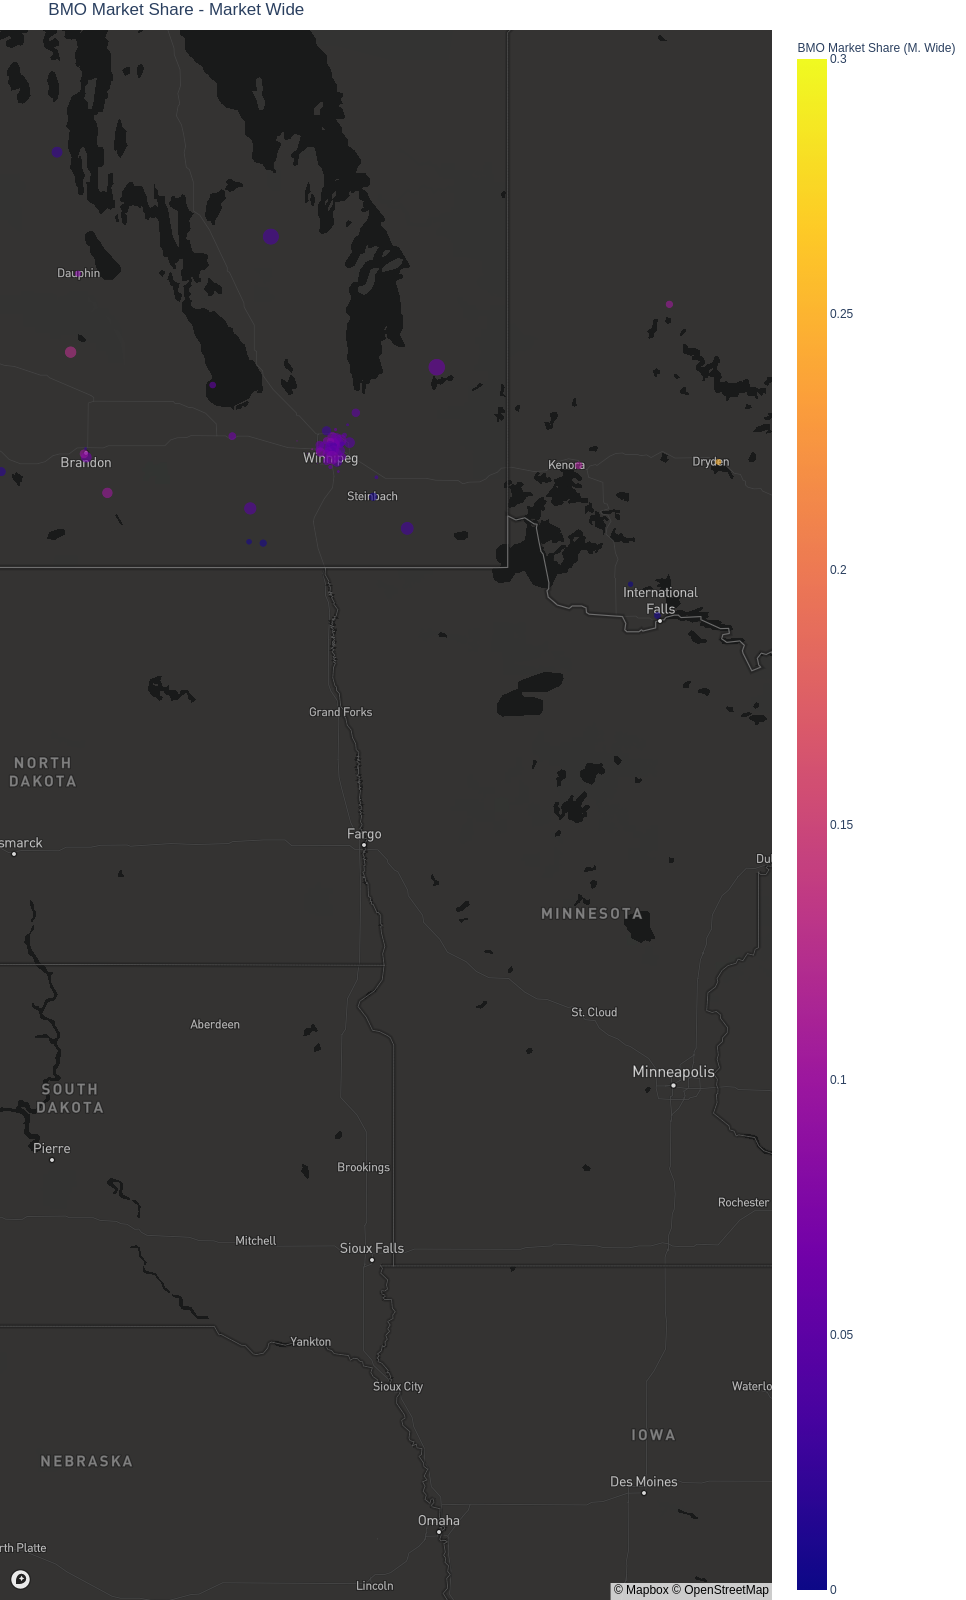

In [140]:
fig = px.scatter_mapbox(postal_6,
                        lat="lat",
                        lon="lon",
                        hover_name="postal_code",
                        hover_data={"place_name":True, "province":True, 'priv_dwell_2016':True, 'avg_null_count':True, 'lat':False, 'lon':False, 'bmo_mkt_share_total':':.2f', 'consumer_cnt_mw':True, 'consumer_cnt_bmo':True},
                        color=list(postal_6['bmo_mkt_share_total']),
                        labels={'consumer_cnt_bmo':'BMO Consumer Count',
                                'consumer_cnt_mw': 'Market-Wide Consumer Count',
                                'place_name': 'Place',
                                'province':'Province',
                                'avg_null_count': 'Avg. Null Fields',
                                'priv_dwell_2016': '2016 Private Dwelling Count',
                                'bmo_mkt_share_total': 'BMO Market Share (M. Wide)',
                                'color':'BMO Market Share (M. Wide)'},
                        range_color = [0, 0.3],
                        size='priv_dwell_2016',
                        size_max=20,
                        opacity=0.6,
                        zoom=3,
                        height=800,
                        title='BMO Market Share - Market Wide',
                        center=go.layout.mapbox.Center(
                lat= 58,
                lon= -90
            ))

fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
# fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

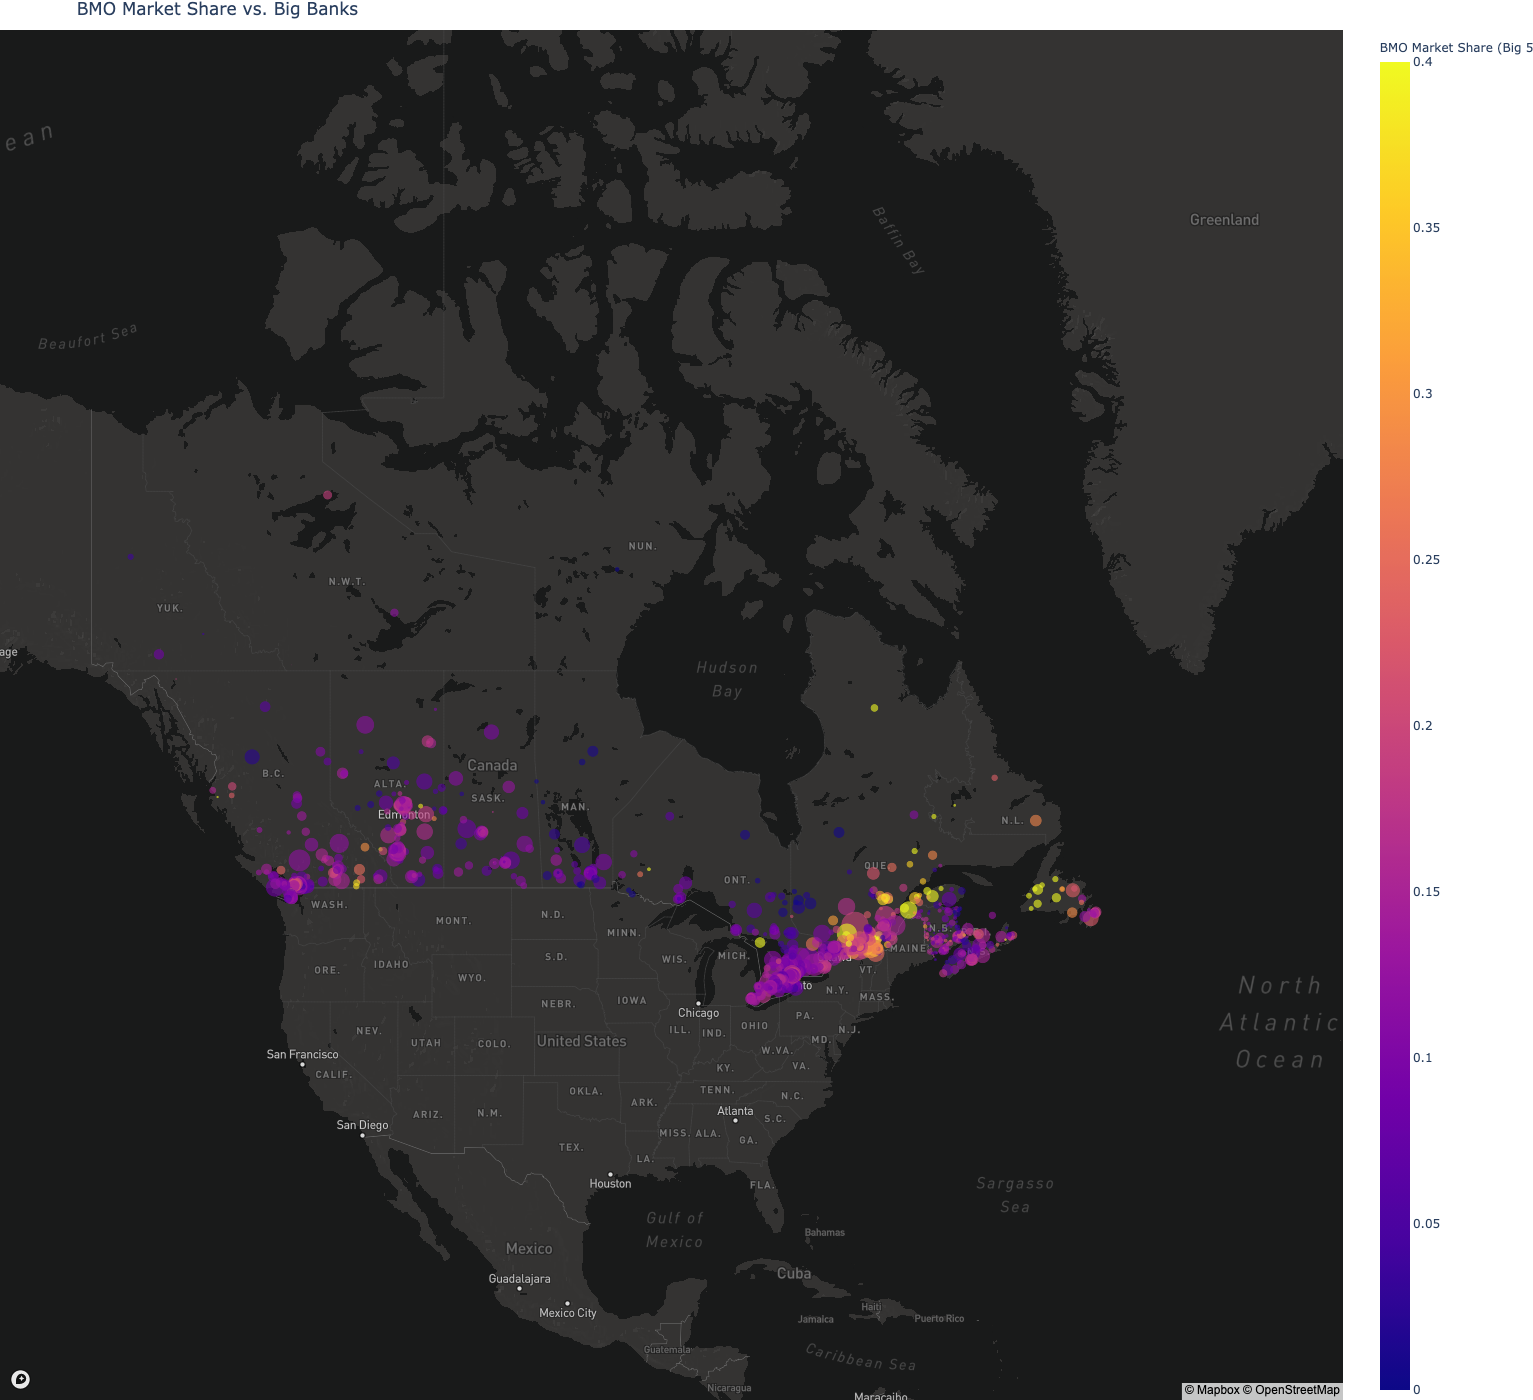

In [147]:
fig = px.scatter_mapbox(postal_6,
                        lat="lat",
                        lon="lon",
                        hover_name="postal_code",
                        hover_data={"place_name":True, "province":True, 'priv_dwell_2016':True, 'avg_null_count':True, 'lat':False, 'lon':False, 'bmo_mkt_share_big_bnks':':.2f', 'consumer_cnt_mb':True, 'consumer_cnt_bmo':True, 'consumer_cnt_mw':True},
                        color=list(postal_6['bmo_mkt_share_big_bnks']),
                        labels={'consumer_cnt_bmo':'BMO Mortgage Count',
                                'consumer_cnt_mb': 'Major Bank Mortgage Count',
                                'consumer_cnt_mw': 'Market-Wide Mortgage Count',
                                'place_name': 'Place',
                                'province':'Province',
                                'avg_null_count': 'Avg. Null Fields',
                                'priv_dwell_2016': '2016 Private Dwelling Count',
                                'bmo_mkt_share_big_bnks': 'BMO Market Share (Big 5)',
                                'color':'BMO Market Share (Big 5)'},
                        range_color = [0, 0.4],
                        size='priv_dwell_2016',
                        size_max=20,
                        opacity=0.6,
                        zoom=3,
                        height=700,
                        title='BMO Market Share vs. Big Banks',
                        center=go.layout.mapbox.Center(
                lat= 58,
                lon= -90
            ))

fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
# fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

Size will be number of private dwellings, color will be BMO total market share

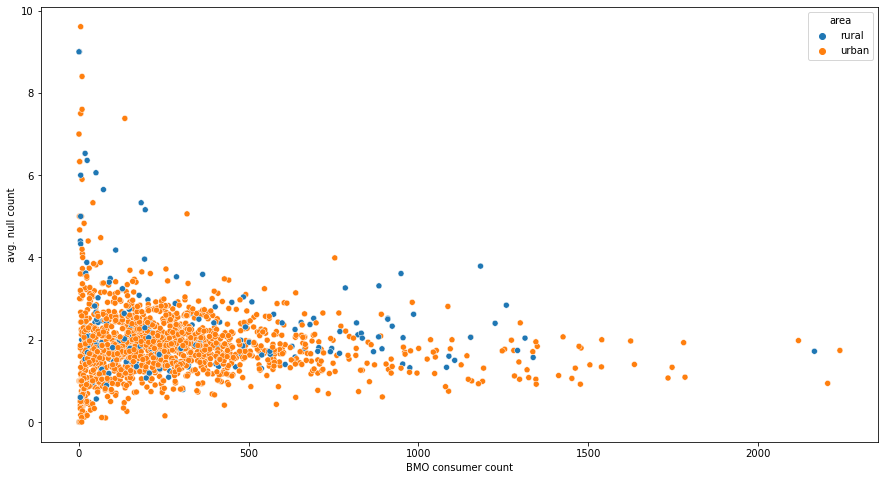

In [179]:
plt.figure(figsize=(15,8))

sns.scatterplot(data=postal_6, x='consumer_cnt_bmo', y='avg_null_count', hue='area')
plt.xlabel('BMO consumer count')
plt.ylabel('avg. null count')

plt.show()

In [148]:
postal_6.head()

postal_code                          place_name province      lat       lon  \
0         T0A          Eastern Alberta (St. Paul)       AB  54.7660 -111.7174   
1         T0B         Wainwright Region (Tofield)       AB  53.0727 -111.5816   
2         T0C          Central Alberta (Stettler)       AB  52.1431 -111.6941   
3         T0E            Western Alberta (Jasper)       AB  53.6758 -115.0948   
4         T0G  North Central Alberta (Slave Lake)       AB  55.6993 -114.4529   

   consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  consumer_cnt_mw  \
0               334            2.36  rural          27713.0             6287   
1               789            2.07  rural          28009.0             6918   
2               669            2.26  rural          28739.0             6612   
3               322            1.43  rural          22179.0             5110   
4               177            1.99  rural          18519.0             4334   

   bmo_mkt_share_total  consumer_cnt_mb  bmo_mkt_share_big_bnks  
0                0.053             4353                   0.077  
1                0.114             4330                   0.182  
2                0.101             4194                   0.160  
3                0.063             3700                   0.087  
4                0.041             3231                   0.055

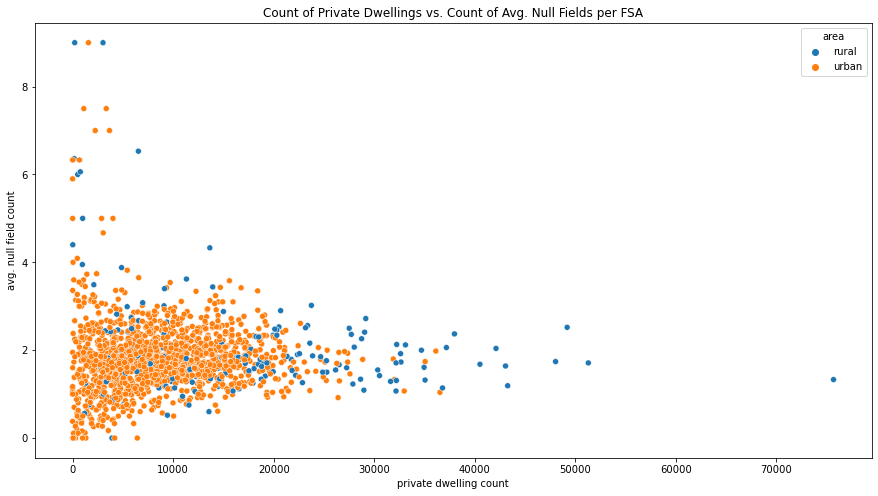

In [154]:
plt.figure(figsize=(15,8))

sns.scatterplot(data=postal_6, x='priv_dwell_2016', y='avg_null_count', hue='area')
plt.title('Count of Private Dwellings vs. Count of Avg. Null Fields per FSA')
plt.xlabel('private dwelling count')
plt.ylabel('avg. null field count')

plt.show()

Somewhat negative association between number of consumers and avg. count of null values per feature. Most poorer quality data comes from FSAs with very low numbers of BMO mortgages, with no distinct change in representation of urban vs. rural FSAs compared to higher concentration FSAs. Urban FSAs are more common in general.  

Insert average mortgage downpayment, appraisal values, income levels etc.

In [155]:
fig = px.scatter_mapbox(postal_4,
                        lat="lat",
                        lon="lon",
                        hover_name="postal_code",
                        hover_data={"place_name":True, "province":True, 'priv_dwell_2016':True, 'lat':False, 'lon':False, 'avg_null_count':True},
                        color=list(postal_4['area']),
                        labels={'consumer_count':'Consumer Count', 'place_name': 'Place', 'province':'Province', 'priv_dwell_2016': '2016 Private Dwelling Count', 'avg_null_count':'Avg. Null Fields', 'color':'Area'},
                        range_color = [1, 4],
                        size='consumer_count',
                        size_max=17,
                        opacity=0.6,
                        zoom=2.8,
                        height=600,
                        title='BMO Data - Urban & Rural',
                        center=go.layout.mapbox.Center(
                lat= 55,
                lon= -90
            ))
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
# fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['postal_code', 'place_name', 'province', 'lat', 'lon', 'consumer_cnt_bmo', 'avg_null_count', 'area', 'priv_dwell_2016'] but received: consumer_count

In [75]:
postal_6.sort_values('province', ascending=True).head()

postal_code                                         place_name  \
644         K0H                                   Frontenac County   
208         V0N                                       North Island   
0           T0A                         Eastern Alberta (St. Paul)   
99          T5Z                      Edmonton (West Lake District)   
100         T6A                          Edmonton (North Capilano)   
101         T6B  Edmonton (SE Capilano / West Southeast Industr...   
102         T6C                     Edmonton (Central Bonnie Doon)   
103         T6E     Edmonton (South Bonnie Doon / East University)   

                                            province      lat       lon  \
644   Loyalist Shores and Southwest Leeds (Inverary)  44.7666  -76.8720   
208             and Southern Gulf Islands (Whistler)  50.5666 -122.6979   
0                                                 AB  54.7660 -111.7174   
99                                                AB  53.6365 -113.4673   
100                                               AB  53.5482 -113.4318   
101                                               AB  53.5128 -113.4194   
102                                               AB  53.5220 -113.4590   
103                                               AB  53.4914 -113.4802   

     consumer_cnt_bmo  avg_null_count   area  priv_dwell_2016  \
644              1107            1.50  rural          25284.0   
208               910            2.52  rural          49181.0   
0                 334            2.36  rural          27713.0   
99                658            1.71  urban          10503.0   
100               234            1.98  urban           6759.0   
101               164            2.24  urban           4257.0   
102               292            2.05  urban          10001.0   
103               355            2.59  urban          13932.0   

     consumer_cnt_mw  bmo_mkt_share_total  consumer_cnt_mb  \
644             7222                0.153             6179   
208            10352                0.088             7589   
0               6287                0.053             4353   
99              5585                0.118             4371   
100             1927                0.121             1430   
101             1601                0.102             1204   
102             2812                0.104             2022   
103             3155                0.113             2328   

     bmo_mkt_share_big_bnks  
644                   0.179  
208                   0.120  
0                     0.077  
99                    0.151  
100                   0.164  
101                   0.136  
102                   0.144  
103                   0.152

In [77]:
postal_6.province.value_counts().sort_values(ascending=True)

 and Southern Gulf Islands (Whistler)                1
 Loyalist Shores and Southwest Leeds (Inverary)      1
NU                                                   2
NT                                                   3
Ontario                                              3
YT                                                   3
New Brunswick                                        4
PE                                                   7
NL                                                  35
SK                                                  47
MB                                                  66
NS                                                  76
NB                                                 106
AB                                                 154
BC                                                 190
QC                                                 415
ON                                                 515
Name: province, dtype: int64

In [78]:
postal_6.loc[postal_6['province'] =='and Southern Gulf Islands (Whistler)']

Empty DataFrame
Columns: [postal_code, place_name, province, lat, lon, consumer_cnt_bmo, avg_null_count, area, priv_dwell_2016, consumer_cnt_mw, bmo_mkt_share_total, consumer_cnt_mb, bmo_mkt_share_big_bnks]
Index: []

In [ ]:
# Inserting / Overwriting missing FSAs with correct values

postal['lat'].loc[(postal['postal_code'] == 'V0N')] = 50.5666
postal['lon'].loc[(postal['postal_code'] == 'V0N')] = -122.6979

postal['lat'].loc[(postal['postal_code'] == 'E1H')] = 46.1946
postal['lon'].loc[(postal['postal_code'] == 'E1H')] = -64.7356

postal['lat'].loc[(postal['postal_code'] == 'E2E')] = 45.4186
postal['lon'].loc[(postal['postal_code'] == 'E2E')] = -65.9664